# Benamou-Brenier

We illustrate in this notebook the fundamental link between static and dynamic optimal transport, as highlighted by {cite}`benamou:00`.

This notebook showcases some math-heavy parts of OTT-JAX and how it can be used to illustrate OT theory, but requires knowledge of a few mathematical concepts of OT theory, such as the {term}`Brenier theorem` and how it can be used to define a ground truth {term}`Monge map`, in addition to familiarity with the {term}`Benamou-Brenier` formulation of OT.


In [1]:
import functools
from typing import Callable, Dict, Optional

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.animation as mpa
import matplotlib.pyplot as plt
from IPython import display

from ott.geometry import costs
from ott.math import legendre
from ott.math import utils as mu
from ott.math import velocity_from_brenier_potential
from ott.tools import plot

In [2]:
def to_video(ani: mpa.FuncAnimation) -> None:
    display.display(display.HTML(ani.to_html5_video()))

## Define a ground truth Brenier potential

We dive into mathematics directly: By virtue of the {term}`Brenier theorem`, one can use any convex potential to define a ground truth optimal transport map, i.e. pick a convex function $\varphi$ to define a {term}`Monge map` $\nabla\varphi$ that is optimal w.r.t. the squared-Euclidean distance . Namely, picking any starting measure $\mu$, we will define $\nu:= \nabla \varphi\#\mu$ and can guarantee that $\nabla\varphi$ is the optimal map linking $\mu$ to $\nu$. 

We start by defining such a convex potential, and make some efforts to avoid using a simple quadratic potential (that would result in an affine map) to define something slightly more elaborate for illustration purposes.

In [3]:
# Matrices to define potential phi
A = jnp.array(((0.9, 0.6), (0.2, -0.5)))  # linear transform
B = jnp.array(((0.2, -0.05), (-0.05, 0.1)))  # positive definite matrix.

assert jnp.linalg.det(B) > 0.0


def phi(x: jnp.ndarray) -> jnp.ndarray:
    """Real-valued convex potential function."""
    return (
        jnp.sum(jnp.log(1.0 + jnp.exp(B @ x)))
        + 0.5 * jnp.sum(jnp.abs(A @ x) ** 1.5)
        + 0.1 * mu.logsumexp(10 * x)
        + x[0]
    )


transport_fn = jax.jit(jax.vmap(jax.grad(phi)))
velocity_brenier = jax.jit(velocity_from_brenier_potential(phi))

We can plot the contours of that potential.

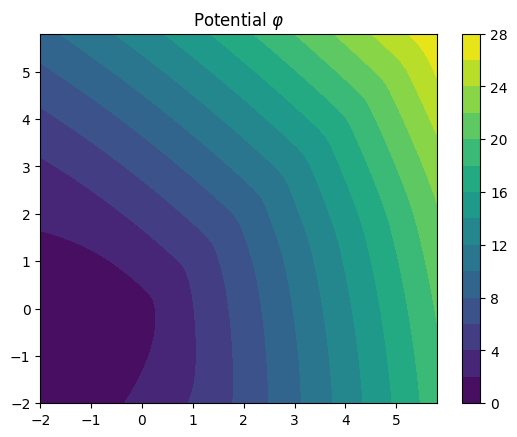

In [4]:
x = np.arange(-2.0, 6.0, 0.2)
y = np.arange(-2.0, 6.0, 0.2)
X, Y = np.meshgrid(x, y)
Z = jnp.array([jnp.array([xx, yy]) for xx, yy in zip(np.ravel(X), np.ravel(Y))])
Z = jax.vmap(phi)(Z).reshape(X.shape)

fig, ax = plt.subplots()
cont = ax.contourf(X, Y, Z.reshape(X.shape), levels=15)
fig.colorbar(cont)
ax.set_title(r"Potential $\varphi$");

## From Brenier Potential to Benamou-Brenier Velocity Field

Our goal in this notebook will be to illustrate solutions to the {term}`Benamou-Brenier` problem that can be inferred from the knowledge of the ground-truth {term}`Monge map` $\nabla\varphi$.

We answer in this prelude a practical question: how can we recover the optimal time-parameterized velocity-field vector $v_t(z)$ (for any $t\in[0,1]$ and point $z$) that solves the {term}`Benamou-Brenier` OT problem formulation corresponding to the map $\nabla\varphi$?

We start from the fundamental relation linking the {term}`Monge map` to the optimal {term}`Benamou-Brenier` velocity field, which is that along an interpolation segment linking $x$ to $\nabla\varphi(x)$, the velocity should be constant:

$$ 
v_t(x + t(\nabla\varphi(x)-x)) = \nabla\varphi(x) -x\,.
$$

Hence, writing $x_t:=x + t(\nabla\varphi(x)-x)$, the first practical task is to reverse
engineer which starting point $x$ may land on $x_t$ on its path to $T(x)=\nabla\varphi(x)$ at time $t$. In particular note that the definition of $x_t$ can be cast as follows:

$$
x_t = \nabla (\tfrac12(1-t)\|\cdot\|^2 + t\varphi)(x)\,.
$$

Since $\varphi_t : = \tfrac12(1-t)\|\cdot\|^2 + t\varphi$ is strictly convex for $t\in[0,1[$, one has therefore that the starting point whose transport segment landed at a given $x_t$ at time $t$ is therefore uniquely determined:

$$
x_t = \nabla \varphi_t(x) \Rightarrow x = \nabla \varphi_t^*(x_t),
$$

where we use the {term}`Legendre transform` of $\varphi_t$, denoted as $\varphi_t^*$. As a result, and for any $z$ and time $t\in[0,1]$, one has:

$$
v_t(z) = \nabla\varphi\circ\nabla \varphi_t^*(z) - \nabla \varphi_t^*(z)\,,
$$

this is exactly the transformation coded in the function {func}`~ott.math.velocity_from_brenier_potential`.

Our goal in this notebook is to illustrate these ground truth {term}`Monge map` and ground truth {term}`Benamou-Brenier` velocity field through a concrete example.

We do so by defining a source point cloud. Here this a simple concatenation of slightly off-centered noisy 2D toruses. For plotting purposes we also sample a smaller subset of these points that we will highlight in plots later on.

In [5]:
batch = 100  # Batch of points.
hl_batch = 10  # Smaller batch to highlight in plots dynamically

# Generate point cloud near the unit circle.


def gen_torus_points(key, fraction=0.7, size=1):
    points = jax.random.normal(key, (size, 2))
    points /= jnp.linalg.norm(points, axis=-1, keepdims=True) + 1e-8
    torus_norms = (
        2 * (1 - fraction) * jax.random.uniform(jax.random.key(1), (size,))
        + fraction
    )
    points *= torus_norms[:, None]
    return points


points = jnp.concatenate(
    (
        gen_torus_points(jax.random.key(0), size=batch),
        gen_torus_points(jax.random.key(1), fraction=0.3, size=batch),
    ),
    axis=0,
)
tgt_points = transport_fn(points)

hl_points = jnp.concatenate(
    (
        gen_torus_points(jax.random.key(2), size=hl_batch) - 0.2,
        gen_torus_points(jax.random.key(3), fraction=0.3, size=hl_batch) + 0.3,
    ),
    axis=0,
)

## Data and Monge Solution

We first plot the source data and the {term}`push-forward` measure obtained by
applying $\nabla\varphi$ to all these source points.

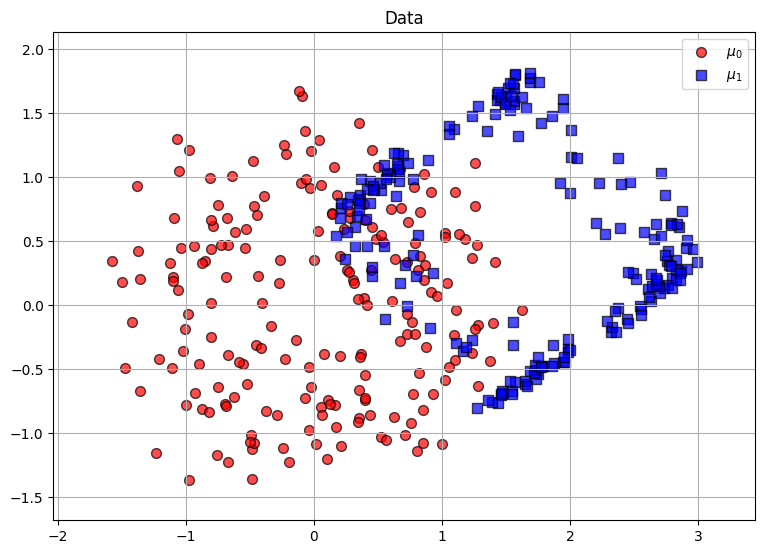

In [6]:
_ = plot.transport_animation(
    n_frames=1,
    title="Data",
    static_src_points=points,
    static_tgt_points=tgt_points,
)

We show more explicitly the {term}`Monge map` linking each source point to its target point.

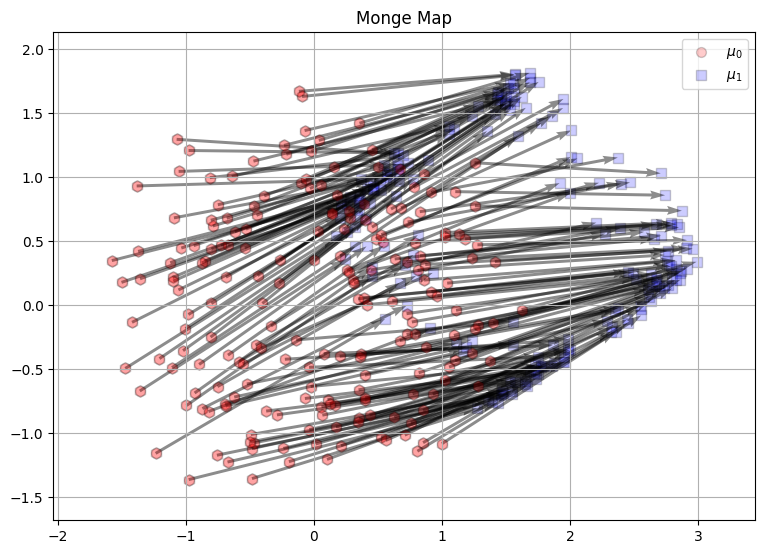

In [7]:
_ = plot.transport_animation(
    n_frames=1,
    static_src_points=points,
    static_tgt_points=tgt_points,
    title="Monge Map",
    velocity_field=velocity_brenier,
)

### McCann Interpolation and Independent Flow Matching

This {term}`Monge map` can be presented in a dynamic view, by plotting all barycenters linking source points to target points, $x_t=(1-t)x + t \nabla\varphi(x)$, to form the so-called McCann interpolation {cite}`mccann:97`.

In [8]:
to_video(
    plot.transport_animation(
        n_frames=11,
        static_src_points=points,
        static_tgt_points=tgt_points,
        velocity_field=velocity_brenier,
        title="McCann Interpolation",
    )
)

As a short digression, the McCann interpolation (which requires the knowledge of the optimal transport map) can be contrasted with the independent coupling interpolation advocated in {term}`flow matching`, e.g. {cite}`lipman:22`, and which is far easier to compute since it involve sampling independently a point from the source, then the target, and then linking them.

In [9]:
to_video(
    plot.transport_animation(
        n_frames=11,
        static_src_points=points,
        static_tgt_points=tgt_points,
        num_ifm_interpolants="all",
        title="Flow-Matching Interpolant",
    )
)

### Benamou-Brenier Solution

We now illustrate the {term}`Benamou-Brenier` solution by displaying the time and space varying vector field $\Delta t \times v_t(\cdot)$. Here $\Delta t$ is the inverse of `(n_frames-1)`.

In [10]:
to_video(
    plot.transport_animation(
        n_frames=11,
        static_src_points=points,
        static_tgt_points=tgt_points,
        dynamic_src_points=jnp.empty([0, 2]),
        n_grid=21,
        velocity_field=velocity_brenier,
        title="Benamou-Brenier Velocity",
    )
)

And illustrate that integration more carefully on one subset of highlighted points.

In [11]:
to_video(
    plot.transport_animation(
        n_frames=11,
        static_src_points=points,
        static_tgt_points=tgt_points,
        dynamic_src_points=hl_points,
        n_grid=21,
        velocity_field=velocity_brenier,
        title="Benamou-Brenier Velocity",
    )
)